In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [49]:
from scipy.stats import norm 


In [50]:
from datetime import datetime, time
import pandas_datareader.data as pdr
#import yfinance as yf

In [51]:
import yfinance as yf

In [52]:
%run -i volatility.py

In [54]:
import math

In [53]:
def black_scholes(s0, k, r, t, sigma, y, option_type):
    T = t/252  #daily to yearly 
    s = s0 * np.exp(-y*T)
    #print(s)
    d1 = (np.log(s0/k) + (((r-y) + (sigma**2)/2)*T))/ (sigma * np.sqrt(T))
    d2 = d1 - (sigma * np.sqrt(T))
    #if d1<0:
    #    n_d1 = 1- norm.cdf(-d1)
    #else:
    #    n_d1 = norm.cdf(d1)
    #if d2<0:
    #    n_d2 = 1- norm.cdf(-d2)
    #else:
     #   n_d2 = norm.cdf(d2)
    #n_d1 = norm.cdf(-d1)
    #n_d2 = norm.cdf(-d2)
    

    #opt = stock.option_chain(expiry)
    #print(opt)
    #vol=0.001*np.arange(1,1001)
   
   #calculating option price and implied volatility
    if option_type == 'Call':
        value = s*norm.cdf(d1,0,1)- k * np.exp(-r*T) * norm.cdf(d2,0,1) 
        #opt_value = opt.calls
        #price = opt_value.loc[opt_value.strike == k, 'lastPrice'].values[0]
        #print(price)
        #im_vol = abs(value - price)*0.1
           

    else:
        #print(option_type)
        value =  (k * np.exp(-r *T)* norm.cdf(-d2,0,1)) - (s* norm.cdf(-d1,0,1))
        #print("k * np.exp(-r *t)* norm.cdf(-d2,0,1)",k * np.exp(-r *t)* norm.cdf(-d2,0,1))
        #print("s* norm.cdf(-d1,0,1)", s* norm.cdf(-d1,0,1))

        #print(value)
        #opt_value = opt.puts
        #price = opt_value.loc[opt_value.strike == k, 'lastPrice'].values[0]
        #im_vol = abs(value - price)*0.1
        
        
    
    # calculating break even point
    if option_type == 'Call': 
        bep = k + value
    else:
        bep = k - value
        
    #delta
    if y >0.0 and T > 0.0:
        yfac = np.exp(-y*T)
    else:
        yfac = 1.0
    
    if option_type == 'Call' : delta = yfac * norm.cdf(d1) 
    else:  delta = yfac* (norm.cdf(d1) -1)
    
    #gamma
    gamma = (yfac * norm.pdf(d1)) /(s0 * sigma * np.sqrt(T))
    
    #theta
    if option_type =='Call':
        theta = (-((s * norm.pdf(d1)*sigma)/(2*np.sqrt(T)) + r * k *np.exp(-r*T)*norm.cdf(d2) - y*s*norm.cdf(d1)))/252
    else:
        theta = (-((s * norm.pdf(d1)*sigma)/(2*np.sqrt(T)) - r * k* np.exp(-r*T)*norm.cdf(d2,0,1) +  y*s*norm.cdf(-d1)))/252
    
    #vega
    vega = (s* np.sqrt(T) * norm.pdf(d1))/100
    
    #rho
    if option_type == 'Call':
        rho =( k * T * np.exp(-r*T)*norm.cdf(d2))/100
    else:
        rho = (-(k * T * np.exp(-r*T)*norm.cdf(-d2,0,1)))/100

    #implied volatility # , "implied volatility  " :im_vol.round(4)

    option_values = {
        "option_type" : option_type,
        "premium" : value.round(4), "Breakeven point": bep.round(4),  "detla" :  delta.round(4), "gamma" : gamma.round(4), 
        "theta" : theta.round(4), "vega" : vega.round(4),'rho' :  rho.round(4)
}
    
    return option_values

In [7]:
def black_scholes_1(S, K, T,y, r, sigma, option='call'):
    d1 = (math.log(S / K) + ((r-y) + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    d2 = (math.log(S / K) + ((r-y) - 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    
    if option == 'call':
        return S *norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    if option == 'put':
        return K * math.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

In [8]:
def BS(s,k,r,t,sigma,type='C'):
    T = t/252
    d1 =  (np.log(s/k) + ((r + sigma**2/2)*T))/ (sigma * np.sqrt(T))
    d2 =  d1 - (sigma * np.sqrt(T))
    try:
        if type == 'C':
            price = s*norm.cdf(d1,0,1) -k*np.exp(-r*T)*norm.cdf(d2,0,1)
        elif type == 'P':
            price = k * np.exp(-r * T) * norm.cdf(-d2,0,1) - s * norm.cdf(-d1,0,1)
    except:
        print("Please input correct parameters")
    
    return price

##### Ticker and expiry date

In [55]:
ticker = 'NVDA'
expiry_date = '09-20-2024'


In [56]:
today = datetime.now().date()
one_year_ago = today.replace(year = today.year-1)

In [57]:
stock = yf.Ticker(ticker)
df = yf.download(ticker,start = one_year_ago, end = today,rounding = True)


[*********************100%%**********************]  1 of 1 completed


In [58]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-09-05,48.22,48.85,47.86,48.55,48.53,382653000
2023-09-06,48.44,48.55,46.58,47.06,47.05,468670000
2023-09-07,45.53,46.34,45.15,46.24,46.23,433330000
2023-09-08,45.94,46.61,45.27,45.57,45.56,473069000
2023-09-11,46.15,46.16,44.31,45.18,45.17,473966000


In [59]:
df_returns = pd.DataFrame()
df_returns['Close'] = df['Close']

In [60]:
df_returns.head()

,Close
Date,
2023-09-05,48.55
2023-09-06,47.06
2023-09-07,46.24
2023-09-08,45.57
2023-09-11,45.18


In [61]:
#calculating returns
df_returns['returns'] = df_returns['Close'].pct_change()

In [62]:
df_returns['cum_ret'] = (df_returns['returns'] +1).cumprod()


In [63]:
df_returns.dropna().head()

,Close,returns,cum_ret
Date,,,
2023-09-06,47.06,-0.030690,0.969310
2023-09-07,46.24,-0.017425,0.952420
2023-09-08,45.57,-0.014490,0.938620
2023-09-11,45.18,-0.008558,0.930587
2023-09-12,44.87,-0.006861,0.924202


In [64]:
log_returns = np.log(df_returns["Close"]/df_returns['Close'].shift(1))

In [65]:
df_returns['log_returns'] = log_returns
df_returns.head()

,Close,returns,cum_ret,log_returns
Date,,,,
2023-09-05,48.55,NaN,NaN,NaN
2023-09-06,47.06,-0.030690,0.969310,-0.031171
2023-09-07,46.24,-0.017425,0.952420,-0.017578
2023-09-08,45.57,-0.014490,0.938620,-0.014596
2023-09-11,45.18,-0.008558,0.930587,-0.008595


#### Plotting returns

<Axes: xlabel='Date', ylabel='Close'>

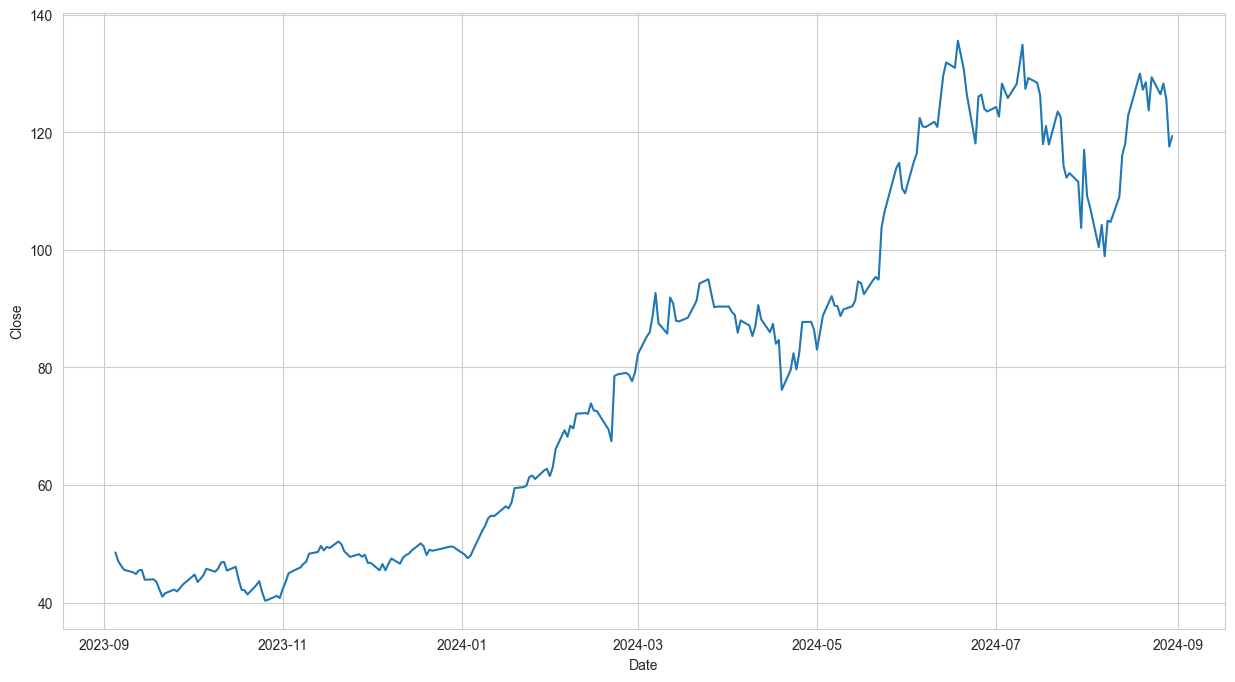

In [66]:
#Visualize the price
sns.set_style('whitegrid')
plt.figure(figsize=(15,8))
sns.lineplot(data = df_returns['Close'] )

<Axes: xlabel='Date', ylabel='log_returns'>

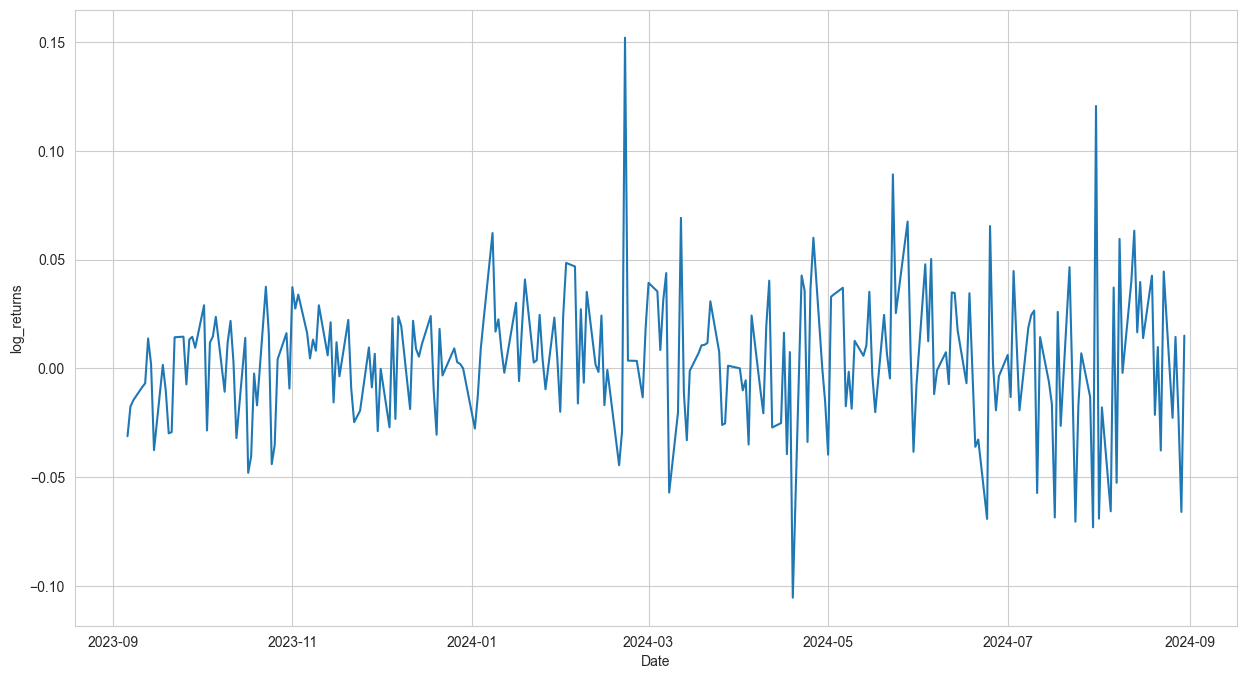

In [67]:
#Visualizing log return
plt.figure(figsize=(15,8))
sns.lineplot(data = df_returns['log_returns'])

<Axes: xlabel='Date', ylabel='cum_ret'>

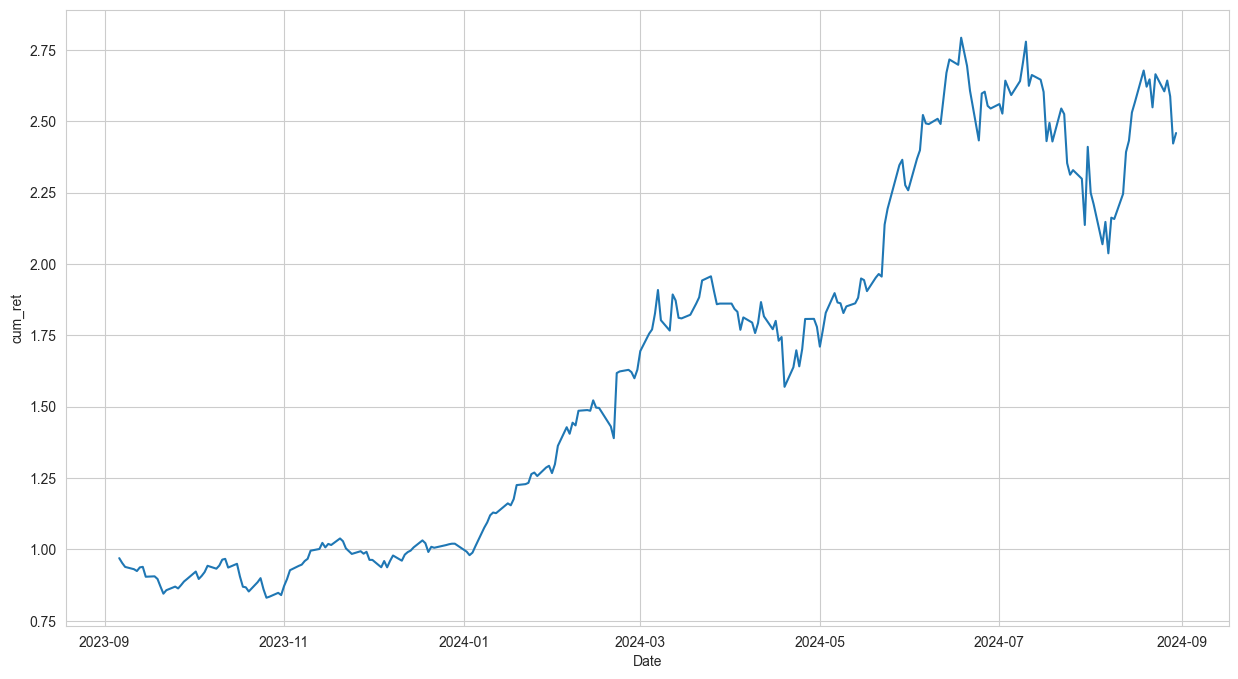

In [68]:
#Visualizing return
plt.figure(figsize=(15,8))
sns.lineplot(data = df_returns['cum_ret'])

Annualised dividend

In [69]:
dividends = stock.history(start= one_year_ago, end = today)['Dividends']
#type(dividends)
annual_div = dividends.sum()
print(annual_div)

0.022


In [70]:
stock.info


{'address1': '2788 San Tomas Expressway',
 'city': 'Santa Clara',
 'state': 'CA',
 'zip': '95051',
 'country': 'United States',
 'phone': '408 486 2000',
 'website': 'https://www.nvidia.com',
 'industry': 'Semiconductors',
 'industryKey': 'semiconductors',
 'industryDisp': 'Semiconductors',
 'sector': 'Technology',
 'sectorKey': 'technology',
 'sectorDisp': 'Technology',
 'longBusinessSummary': "NVIDIA Corporation provides graphics and compute and networking solutions in the United States, Taiwan, China, Hong Kong, and internationally. The Graphics segment offers GeForce GPUs for gaming and PCs, the GeForce NOW game streaming service and related infrastructure, and solutions for gaming platforms; Quadro/NVIDIA RTX GPUs for enterprise workstation graphics; virtual GPU or vGPU software for cloud-based visual and virtual computing; automotive platforms for infotainment systems; and Omniverse software for building and operating metaverse and 3D internet applications. The Compute & Networki

In [71]:
#Dividend yield
div_yield = stock.info['dividendYield']
print(div_yield)

0.00029999999


##### Sigma 

In [28]:
#one year volatility
sigma = (df_returns['log_returns'].std())*np.sqrt(252)
print(sigma)

0.49229266091716195


In [29]:
sigma_1 = (df_returns['returns'].std())*np.sqrt(252)
print(sigma_1)

0.4974322136013893


In [30]:
def returns(window,trading_periods):
    result = log_returns.rolling(window,center=False).std()* np.sqrt(trading_periods)
    return result

In [32]:
def returns_normal(window,trading_periods):
    result = df_returns['returns'].rolling(window,center=False).std()* np.sqrt(trading_periods)
    return result

In [33]:
returns_normal(20,252)

Date
2023-08-29         NaN
2023-08-30         NaN
2023-08-31         NaN
2023-09-01         NaN
2023-09-05         NaN
                ...   
2024-08-22    0.808851
2024-08-23    0.820881
2024-08-26    0.824786
2024-08-27    0.771682
2024-08-28    0.644583
Name: returns, Length: 252, dtype: float64

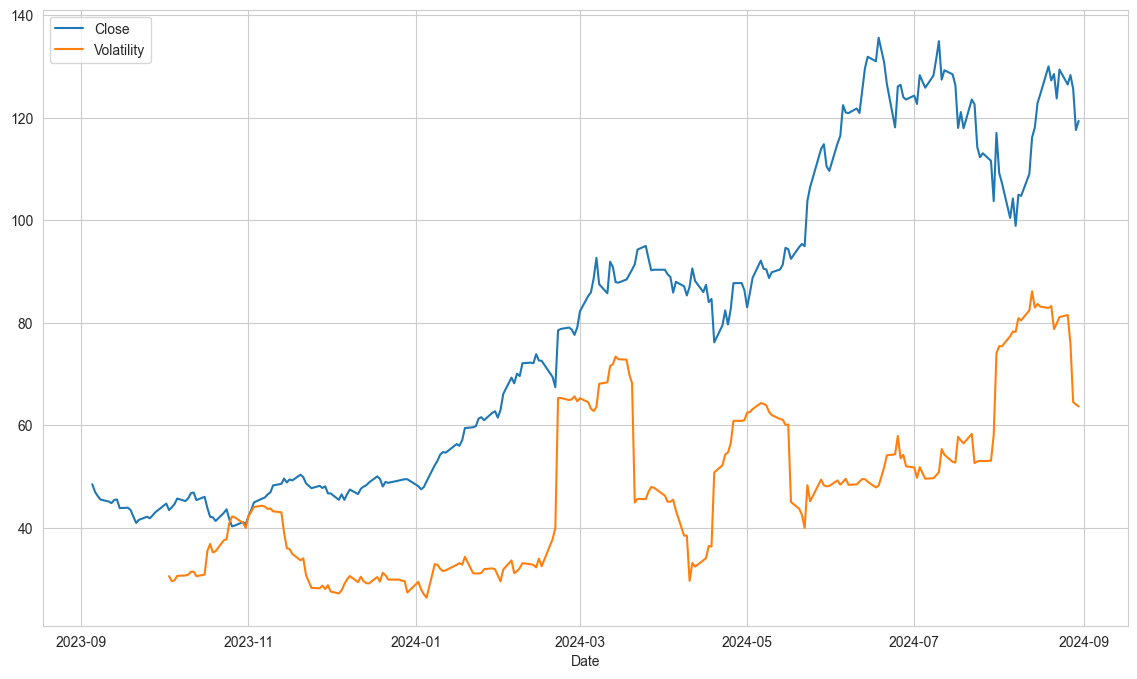

In [81]:

plt.figure(figsize=(14,8))
plt.plot(df_returns.index, df_returns['Close'], label="Close")
plt.plot( std_dev(df)*100, label='Volatility')
plt.xlabel('Date')
plt.legend(loc=2)

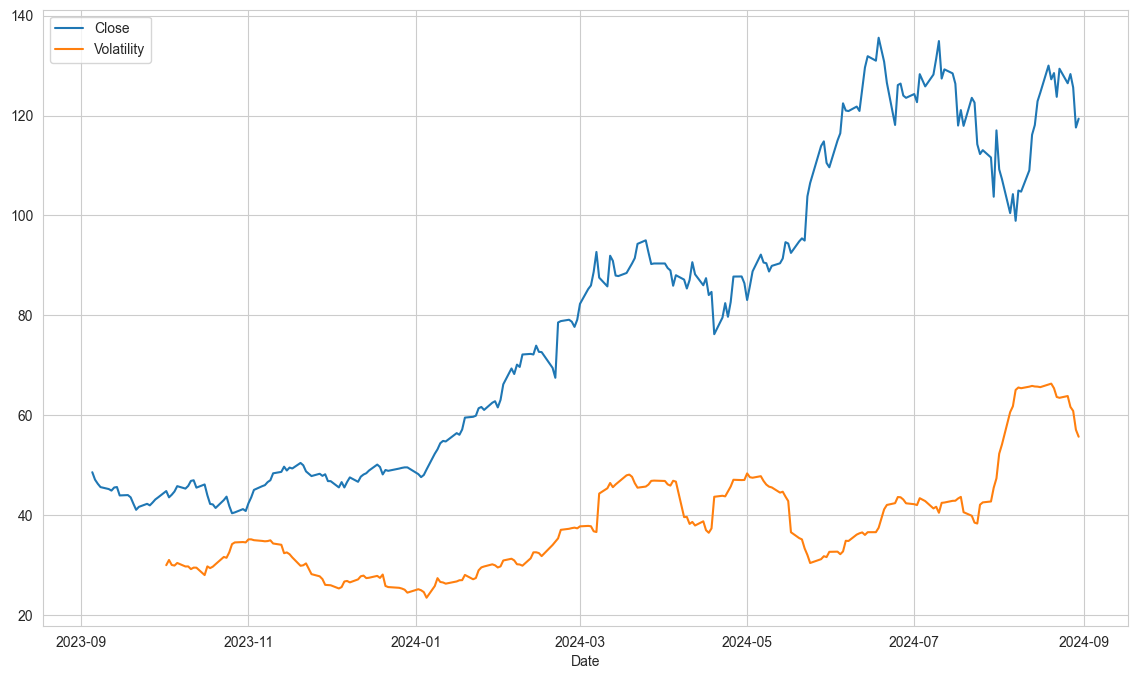

In [82]:

plt.figure(figsize=(14,8))
plt.plot(df_returns.index, df_returns['Close'], label="Close")
plt.plot( parkison_vol(df)*100, label='Volatility')
plt.xlabel('Date')
plt.legend(loc=2)

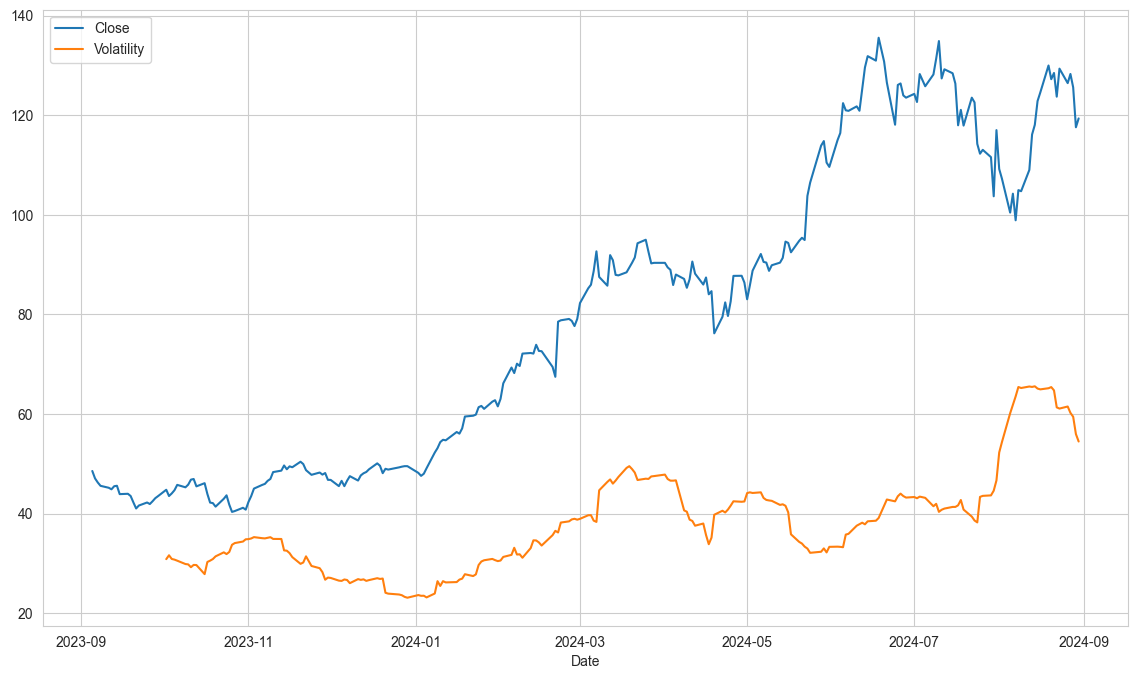

In [83]:

plt.figure(figsize=(14,8))
plt.plot(df_returns.index, df_returns['Close'], label="Close")
plt.plot( garman_klass(df)*100, label='Volatility')
plt.xlabel('Date')
plt.legend(loc=2)

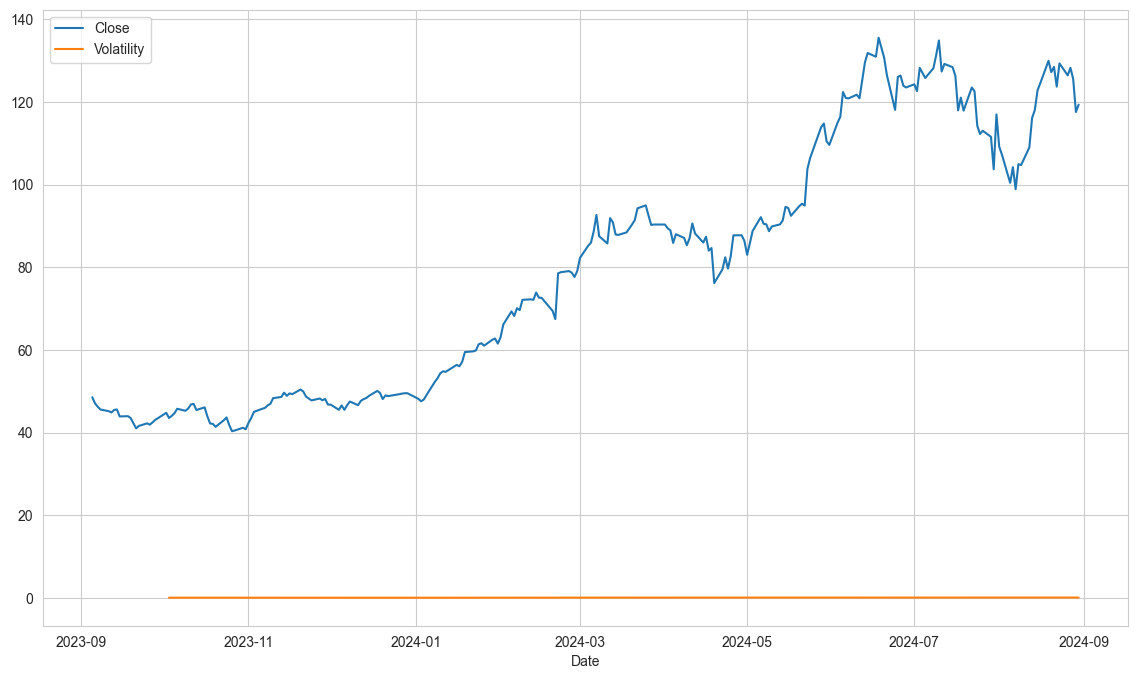

In [90]:

plt.figure(figsize=(14,8))
plt.plot(df_returns.index, df_returns['Close'], label="Close")
plt.plot( yang_zhang(df), label='Volatility')
plt.xlabel('Date')
plt.legend(loc=2)

In [92]:
yang_zhang(df)

Date
2023-09-05         NaN
2023-09-06         NaN
2023-09-07         NaN
2023-09-08         NaN
2023-09-11         NaN
                ...   
2024-08-26    0.060462
2024-08-27    0.059929
2024-08-28    0.055604
2024-08-29    0.055094
2024-08-30    0.053434
Length: 250, dtype: float64

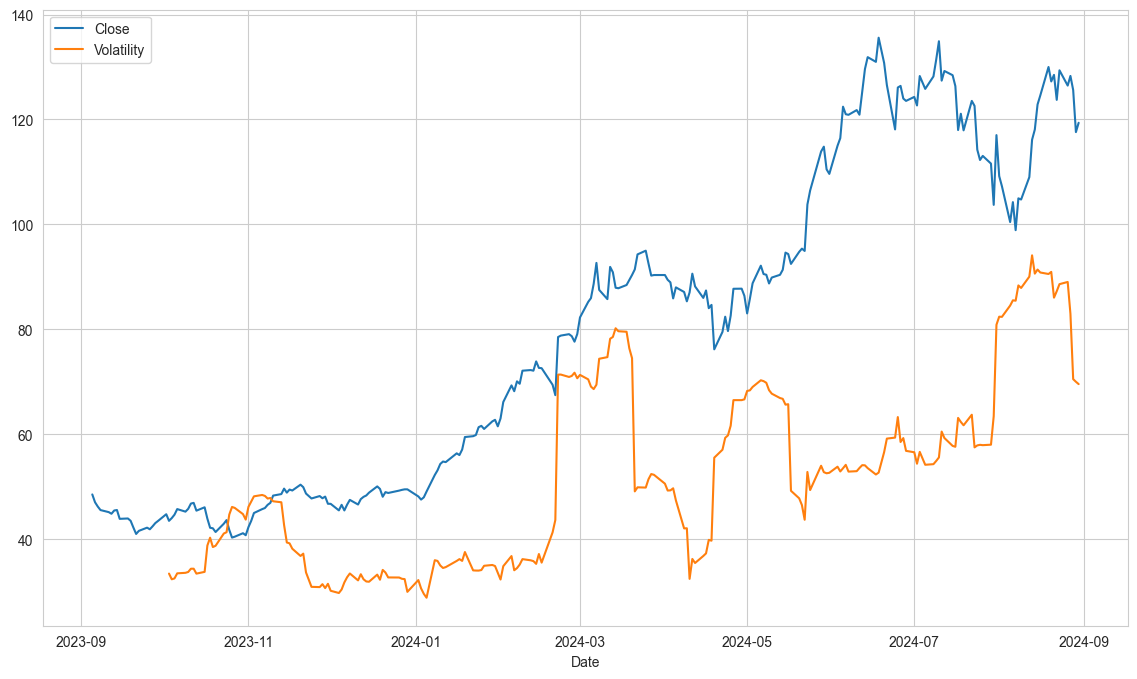

In [88]:
hodges_tompkins(df)
plt.figure(figsize=(14,8))
plt.plot(df_returns.index, df_returns['Close'], label="Close")
plt.plot(hodges_tompkins(df)*100, label='Volatility')
plt.xlabel('Date')
plt.legend(loc=2)

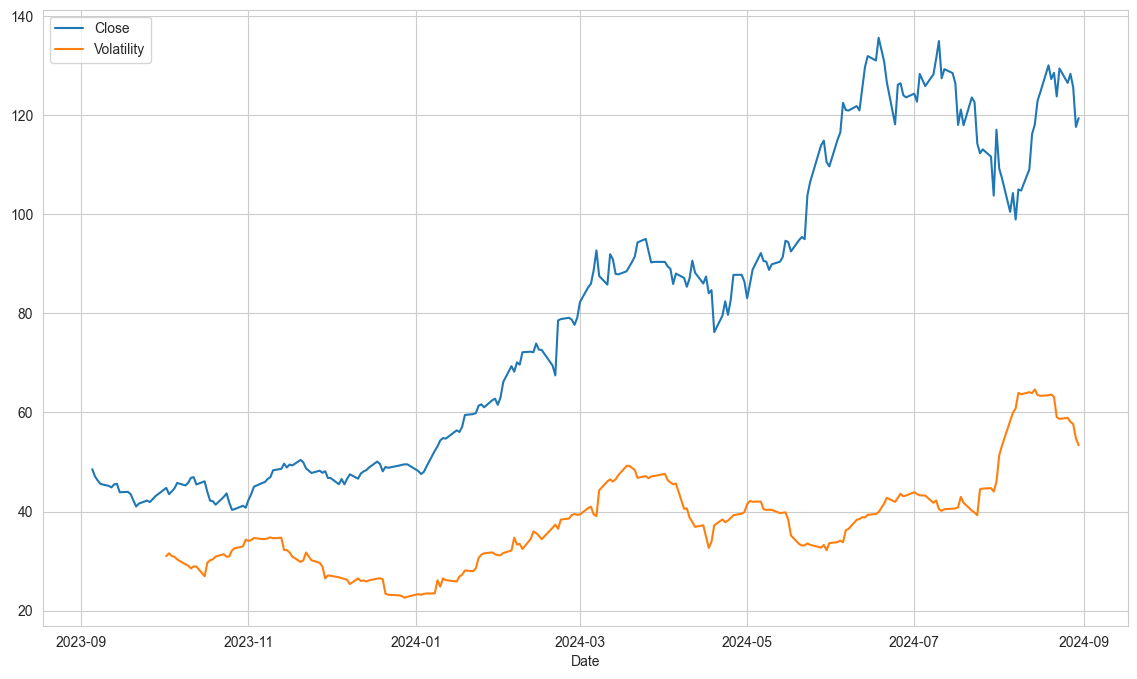

In [89]:
rogers_satchell(df)
plt.figure(figsize=(14,8))
plt.plot(df_returns.index, df_returns['Close'], label="Close")
plt.plot( rogers_satchell(df)*100, label='Volatility')
plt.xlabel('Date')
plt.legend(loc=2)

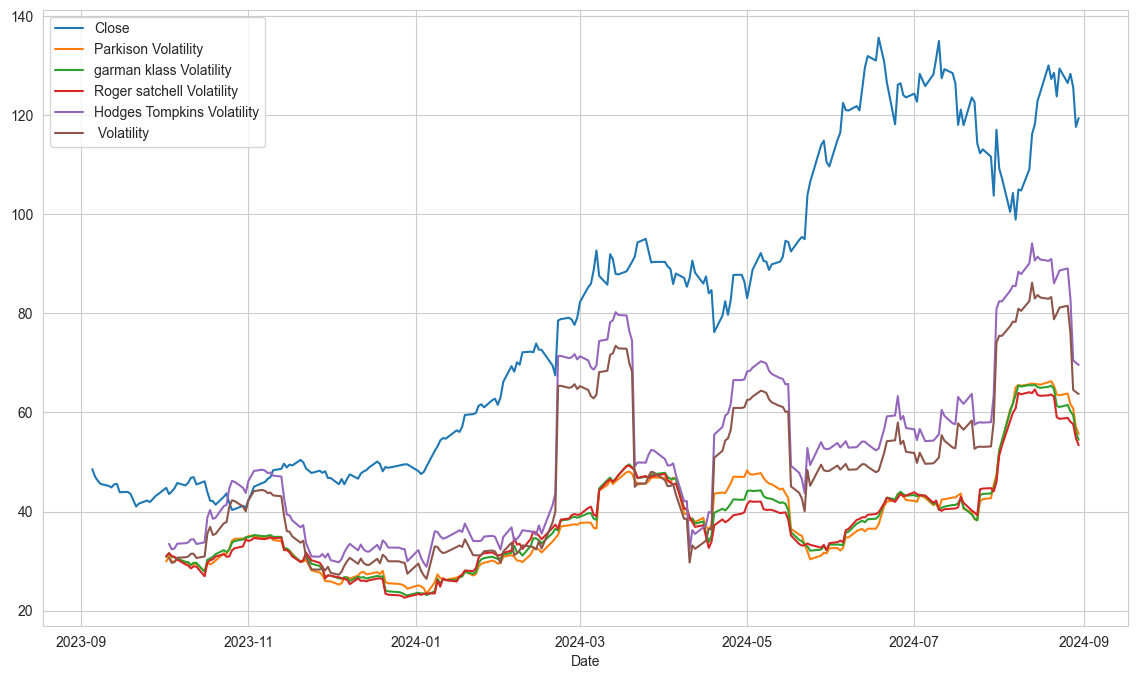

In [93]:
plt.figure(figsize=(14,8))
plt.plot(df_returns.index, df_returns['Close'], label="Close")
plt.plot( parkison_vol(df)*100, label='Parkison Volatility')
plt.plot( garman_klass(df)*100, label='garman klass Volatility')
plt.plot( rogers_satchell(df)*100, label='Roger satchell Volatility')
plt.plot( hodges_tompkins(df)*100, label='Hodges Tompkins Volatility')
plt.plot( std_dev(df)*100, label=' Volatility')
plt.xlabel('Date')
plt.legend(loc=2)

#### Risk-free rate

In [34]:
#risk-free rate, as the 6 month U.S. treasury yield which could get from ^TNX
r = 0.0538*100
print(r)

5.38


In [35]:
def get_10yr_treasury_rate():
    # 10 year treasury ticker symbol
    treasury_ticker = "^TNX"
    now = datetime.now()
    ten_years_ago = now.replace(year=now.year - 10)
    treasury_data = yf.download(treasury_ticker, start=ten_years_ago, end=now)
    last_yield = treasury_data['Close'].iloc[-1]
    return last_yield

In [36]:
last_yield = get_10yr_treasury_rate()
print(last_yield)

[*********************100%%**********************]  1 of 1 completed

3.8410000801086426


#### Current stock price

In [37]:
#current stock price
s = df_returns['Close'].iloc[-1]
print(s)

125.61


#### Time

In [72]:
# time remaining untill expiration in days
t = (datetime.strptime(expiry_date, "%m-%d-%Y") - datetime.utcnow()).days +1
t

17

In [39]:
vol =[]
vol= returns(t,252).to_list()
print(vol[-1])

0.78161299542386


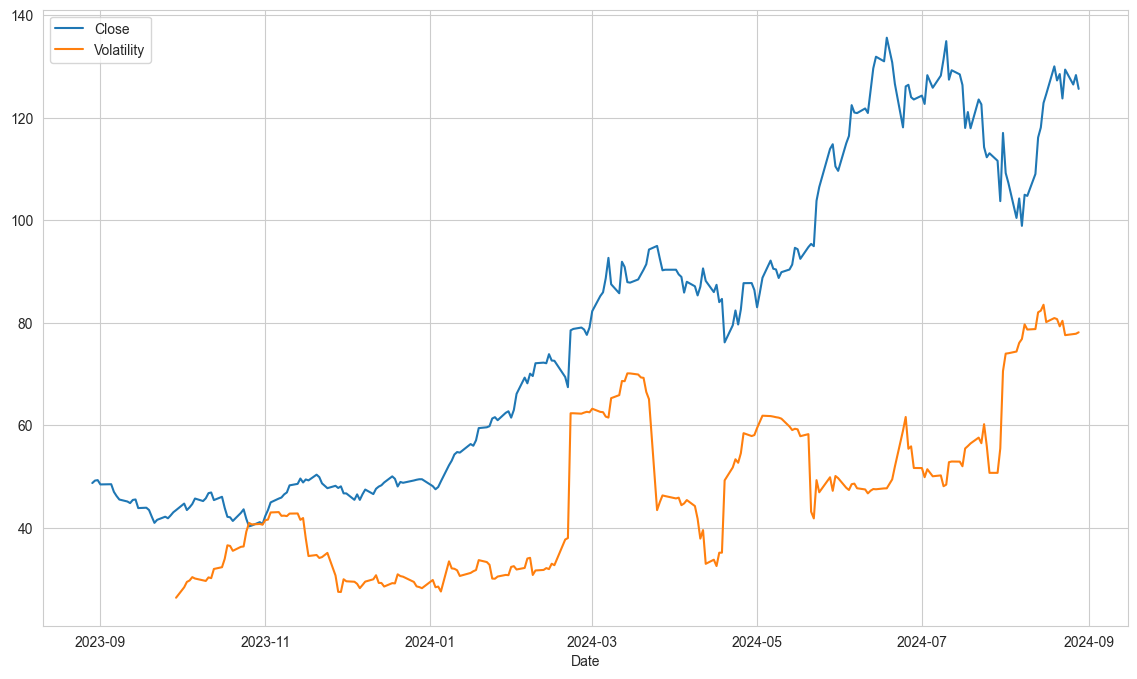

In [41]:
#Visualizing the volatility
plt.figure(figsize=(14,8))
plt.plot(df_returns.index, df_returns['Close'], label="Close")
plt.plot( returns(t,252)*100, label='Volatility')
plt.xlabel('Date')
plt.legend(loc=2)

In [46]:
#volatility for remaining time
t_years = t/12
v_t = sigma*np.sqrt(t_years)
print(v_t)

0.666567413935242


#### Strike price

In [586]:
strike_price = 115
#sigma = 0.21842

Option price from yahoo finance

In [587]:
#expiry date for option price
expiry_date_new = "2024-09-20"


#### Calculating option value

In [589]:
BS(s,strike_price,last_yield/100,t,vol[-1]/100,'P')

np.float64(6.397076824608568)

In [590]:
BS(s,strike_price,last_yield/100,t,sigma,'P')

np.float64(2.799888546236506)

In [601]:
black_scholes(s, strike_price, last_yield/100, t,vol[-1]/100,div_yield, 'Put')

{'option_type': 'Put',
 'premium': np.float64(6.3981),
 'Breakeven point': np.float64(108.6019),
 'detla': np.float64(-0.3043),
 'gamma': np.float64(0.0121),
 'theta': np.float64(-0.2201),
 'vega': np.float64(0.1299),
 'rho': np.float64(-0.039)}

In [593]:
black_scholes_1(s, strike_price, t_years,last_yield/100,div_yield, vol[-1]/100, option='put')

np.float64(6.5457466858330235)

#### Calculating probability of profit

POP = N[d2(S1)] - N[d2(S2)] 
where S1 < S2; N - cumulative distribution function assuming normal distribution

In [594]:
def d2_norm_cdf(s,k,sigma, r, t):
    T = t/252
    d2 = -(np.log(k/s) - (r - (sigma**2))*T) / (sigma * np.sqrt(T))
    return norm.cdf(d2)
    

In [595]:
s1 = 115
s2 = 125

In [596]:
#calculating probabiltiy of profit
pop = (d2_norm_cdf(s2,strike_price,sigma,r,t) - d2_norm_cdf(s1,strike_price,sigma,r,t))*100
print(" Probability of Profit is .{0:8.4f}%".format(pop) )

 Probability of Profit is .  0.0895%
